In [14]:
n = 32
overlap = 4
window_size = 16
# Indices
indices = []
for s in range(0, n):
    stripe = 2**s
    if n / stripe < window_size:
        break
    indices += [range(i, min((i + window_size) * stripe, n), stripe) for i in range(0, n, (window_size - overlap) * stripe)]
indices


[range(0, 16), range(12, 28), range(24, 32), range(0, 32, 2), range(24, 32, 2)]

In [20]:
r = range(0, 2, 2)
int(r.step)


2

In [ ]:
import numpy as np
from mayavi import mlab
from pyvirtualdisplay import Display

display = Display(visible=0, size=(1280, 1024))
display.start()

mlab.options.offscreen = True

################################################################################
# Disable the rendering, to get bring up the figure quicker:
figure = mlab.figure(size=(1024, 1024))
mlab.clf()
figure.scene.disable_render = True

# Creates two set of points using mlab.points3d: red point and
# white points
x1, y1, z1 = np.random.random((3, 10))
red_glyphs = mlab.points3d(x1, y1, z1, color=(1, 0, 0),
                resolution=20)

x2, y2, z2 = np.random.random((3, 10))
white_glyphs = mlab.points3d(x2, y2, z2, color=(1, 0, 0),
                resolution=20)

# Add an outline to show the selected point and center it on the first
# data point.
outline = mlab.outline(line_width=3)
outline.outline_mode = 'cornered'
outline.bounds = (x1[0]-0.1, x1[0]+0.1,
                  y1[0]-0.1, y1[0]+0.1,
                  z1[0]-0.1, z1[0]+0.1)

# Every object has been created, we can reenable the rendering.
figure.scene.disable_render = False
################################################################################

mlab.savefig('output.png')

********************************************************************************
         to build the TVTK classes (9.2). This may cause problems.
         Please rebuild TVTK.
********************************************************************************



: 

(22, 3, 500)
(26, 3, 500)


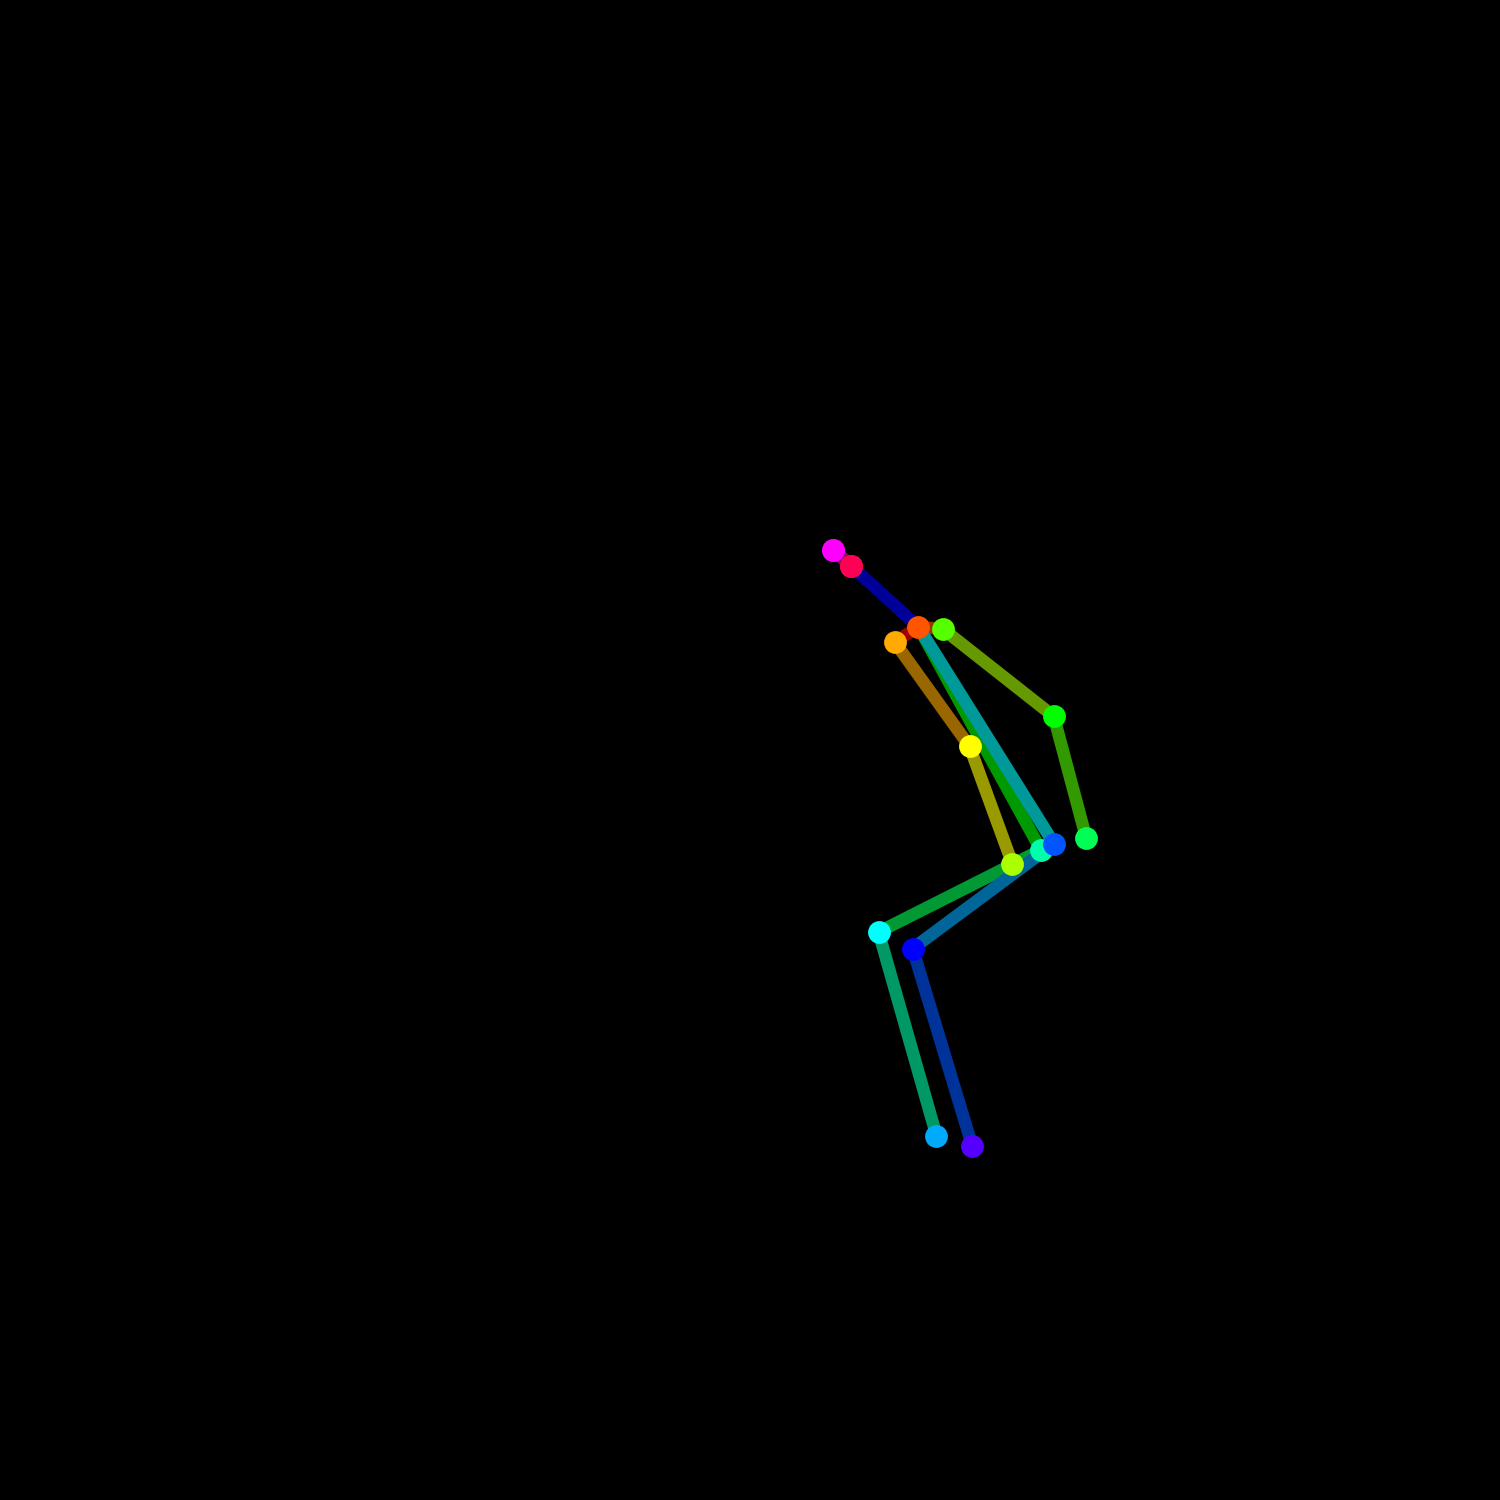

In [69]:
import torch
from diffusers import AutoencoderKL, ControlNetModel, MotionAdapter
from diffusers.pipelines import DiffusionPipeline
from diffusers.schedulers import DPMSolverMultistepScheduler
import io
from PIL import Image
import numpy as np
import imageio
import matplotlib.pyplot as plt
import matplotlib
import math

results = np.load('./priorMDM/save/my_humanml_trans_enc_512/DoubleTake_samples_my_humanml_trans_enc_512_000200000_seed10_handshake_20_double_take_blend_10_skipSteps_100/results.npy', allow_pickle=True).item()
motion = results['motion'][0]
fig = plt.figure(figsize=(5,5))

ax = fig.add_subplot(111, projection='3d')

# https://stackoverflow.com/questions/25575729/how-to-zoom-with-axes3d-in-matplotlib

RADIUS = 1.0  # Control this value.
ax.set_xlim3d(-RADIUS / 2, RADIUS / 2)
ax.set_zlim3d(-RADIUS / 2, RADIUS / 2)
ax.set_ylim3d(-RADIUS / 2, RADIUS / 2)

# https://observablehq.com/@hellonearthis/bwalker-to-open-pose

print(motion.shape) # (22, 3, 500)

# Fill to (26, 3, 500) for openpose
motion = np.concatenate((motion, np.zeros((4, 3, 500))), axis=0)
print(motion.shape) # (26, 3, 500)

joints = [
    (1,'#0055FF'),
    (2,'#00FFAA'),
    (4,'#0000FF'),
    (5,'#00FFFF'),
    (7,'#5500FF'),
    (8,'#00AAFF'),
    (9,'#FF5500'),
    (12,'#FF0000'),
    # (15,'#000000'),
    (16,'#55FF00'),
    (17,'#FFAA00'),
    (18,'#00FF00'),
    (19,'#FFFF00'),
    (20,'#00FF55'),
    (21,'#AAFF00'),
    (22, '#FF0055'),
    (23, '#FF00FF'),
    (24, '#FF00AA'),
    (25, '#AA00FF')
]

connections = [
    ((9,1),'#009999'),
    ((1,4),'#006699'),
    ((4,7),'#003399'),
    ((9, 2),'#009900'),
    ((2,5),'#009933'),
    ((5,8),'#009966'),
    ((17,19),'#996600'),
    ((19, 21),'#999900'),
    ((16, 18),'#669900'),
    ((18, 20),'#339900'),
    ((16, 9),'#993300'),
    ((17, 9),'#990000'),
    ((9, 12),'#000099'),
    ((22, 23), '#990066'), # 660099
    ((23, 12), '#990099'), # 330099
    ((24, 25), '#660099'), # 990066
    ((25, 12), '#330099')  # 990099
]

images = []
i = 160

ax.set_box_aspect((1,1,1))
ax.view_init(70, 0, 90)
ax.set_axis_off()
ax.set_facecolor((0,0,0))

zoom = 0.9
ax.axes.set_xlim3d(left=-zoom, right=zoom)
ax.axes.set_ylim3d(bottom=0, top=zoom*2)
ax.axes.set_zlim3d(bottom=-zoom, top=zoom)

# Calculate neck joint (center of shoulders)
for j in range(3):
    motion[9][j][i] = (motion[13][j][i] + motion[14][j][i]) / 2

# Calculate normal vector from points 9, 12, 15
p1 = np.array([motion[9][0][i], motion[9][1][i], motion[9][2][i]])
p2 = np.array([motion[12][0][i], motion[12][1][i], motion[12][2][i]])
p3 = np.array([motion[15][0][i], motion[15][1][i], motion[15][2][i]])
v1 = p2 - p1
v2 = p3 - p1
cp = np.cross(v1, v2)
cp = (cp / np.linalg.norm(cp)) / 1000

# Calculate eye vector
eye_vec = (v1 / np.linalg.norm(v1)) / 20

# Make head bigger (multiply by 2)
for j in range(3):
    motion[12][j][i] = motion[9][j][i] + (motion[12][j][i] - motion[9][j][i]) * 2

for j in range(3):
    motion[22][j][i] = motion[12][j][i] + cp[j]
    motion[23][j][i] = motion[12][j][i] + cp[j] * 0.5 + eye_vec[j]
    motion[24][j][i] = motion[12][j][i] + -cp[j]
    motion[25][j][i] = motion[12][j][i] + -cp[j] * 0.5 + eye_vec[j]

for joint in joints:
    ax.scatter(motion[joint[0]][0][i], motion[joint[0]][1][i], motion[joint[0]][2][i], color=joint[1])

for con in reversed(connections):
    ax.plot([motion[con[0][0]][0][i], motion[con[0][1]][0][i]], [motion[con[0][0]][1][i], motion[con[0][1]][1][i]], [motion[con[0][0]][2][i], motion[con[0][1]][2][i]], color=con[1], linewidth=3)

fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
buf = io.BytesIO()
fig.savefig(buf, dpi=300)
im = Image.open(buf)
images.append(im)
# buf.close()
ax.clear()
im
